# Tutorial: linux mínimo e busybox rodando no qemu   

## Sobre esse tutorial
* O objetivo deste tutorial é apresentar alguns conceitos e passos necessários na compilação do linux e busybox para rodar no qemu 
* O que será visto:
 * Análise do hardware emulado pelo [Qemu](https://www.qemu.org/)
 * Criação de uma imagem de sistema de arquivos raiz (rootfs) com [Busybox](https://busybox.net/)
 * Compilação mínima do linux para suporte a máquina emulada 
 * Execução do qemu utilizando o linux compilado, utilizando-se o rootfs
* O tutorial é uma atualização do [Compilação do Linux+Busybox para execução no Qemu](http://www.inf.ufg.br/~marceloakira/so-ec-2012-2/aula07/RoteiroCompilacaoLinuxBusyboxParaQemu.html) produzido em 2012 
* Acompanhe atualizações, colabore ou crie um fork, acessando o [código-fonte](https://gitlab.com/marceloakira/tutorial/tree/master/mini-linux+busybox-run-in-qemu) 
* Visualize no formato de apresentação em [slides](http://marceloakira.gitlab.io/tutorial/mini-linux+busybox-run-in-qemu.html#/) 
* Demonstrações da execução deste tutorial são [gravados em vídeo no youtube](https://www.youtube.com/mainuzuka)
* O tutorial é dividido em 4 partes: I - Introdução; II - Criação do sistema de arquivos raiz (rootfs); III - Compilação do kernel; IV - Execução do kernel com rootfs

# Parte I: Introdução 


Para melhor aproveitar esse tutorial, sugere-se algumas leituras prévias:
* [Documentação do Qemu](https://www.qemu.org/documentation/): [manual](https://qemu.weilnetz.de/doc/qemu-doc.html), [opções de inicialização do linux](https://qemu.weilnetz.de/doc/qemu-doc.html#Linux_002fMultiboot-boot-specific), [opções de dispositivos de blocos](https://qemu.weilnetz.de/doc/qemu-doc.html#Block-device-options), [opção -append](https://qemu.weilnetz.de/doc/qemu-doc.html#index-_002dappend)
* Busybox: [FAQ](https://busybox.net/FAQ.html), [Artigo da IBM](https://www.ibm.com/developerworks/linux/library/l-busybox/), [Manual](https://busybox.net/downloads/BusyBox.html), [Conceito de Sistema de arquivos raiz](http://www.linfo.org/root_filesystem.html)
* Comandos do Linux: dd, mount, mkfs, mknod
* Linux: [Kernel e Módulos](http://www.guiafoca.org/cgs/guia/inic_interm/ch-kern.html), [Dispositivos](http://pt.wikiversity.org/wiki/Introdu%C3%A7%C3%A3o_aos_Sistemas_Operacionais/Ger%C3%AAncia_de_Dispositivos), 

# Qemu

* É um software que permite emular virtualmente uma máquina e rodar um SO na mesma;
* O SO que roda na Máquina Virtual (MV) é chamado de convidado (guest);
* O SO que roda na máquina real é chamado de hospedeiro (host);
* Outros softwares de emulação de máquinas: Virtualbox, VMWare, Xen, etc;

## Qemu no estudo de Sistemas Operacionais

* permite:
 * emular uma máquina virtual diferente da máquina real, por exemplo, ARM em Intel;
 * emular um dispositivo de hardware não disponível na prática (serial, paralelo, usb, interface de rede, etc);
 * emular uma rede local e realizar testes entre: Host e Guest; MVs.
* agiliza os testes e o desenvolvimento de kernel:
 * compilar e testar um novo núcleo sem reiniciar a máquina real;

# Parte II: Criação do sistema de arquivos raiz

A primeira parte deste tutorial consiste na criação de um sistema de arquivos raiz (rootfs), que consiste em um [sistemas de arquivos](https://en.wikipedia.org/wiki/File_system) que controla como os dados são armazenados e recuperados e no qual o diretório raiz estará localizado.

O Sistema operacional a ser utilizado é uma máquina virtual com Debian 10, que pode ser [baixada](http://www.inf.ufg.br/~marceloakira/vms/Debian10-xfce4.ova) e acessada com usuário/senha: teste/123456 ou root/123456. 

# Instalação do qemu

Para instalar o qemu, execute:

```bash
$ sudo apt update
$ sudo apt install qemu qemu-system-x86
```

No nosso caso, o qemu instalado foi para [arquitetura x86](https://pt.wikipedia.org/wiki/X86). 

# Executando o kernel do sistema com o qemu

Para testar o qemu, execute o kernel do próprio sistema:

```bash
$ ls /boot/vmlinuz*
/boot/vmlinuz-4.19.0-5-amd64
$ qemu-system-x86_64 -kernel /boot/vmlinuz-4.19.0-5-amd64 
```
Note que o kernel é executado, no entanto, ocorre uma falha prevista: 

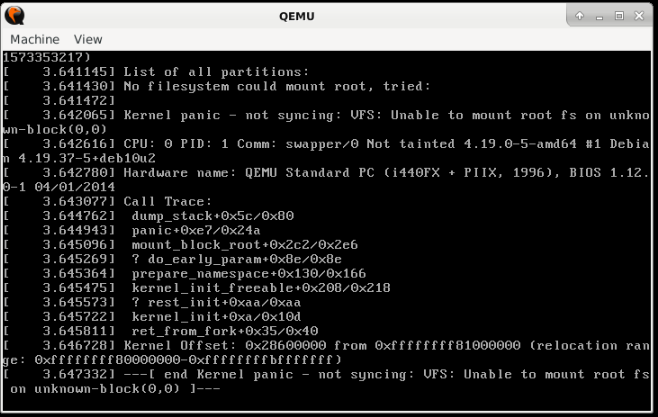

O núcleo reportou "... Unable to mount root fs ..." - ou seja, não conseguiu montar um sistema de arquivos raiz (rootfs). Isso ocorreu pois nenhum rootfs foi fornecido.

# Criação de um sistema de arquivos raiz

O sistema de arquivos raiz é onde ficam todos arquivos do sistema: scripts, drivers, bibliotecas, aplicativos, etc. Podemos criar um sistema de arquivos raiz em disco ou emulá-lo em um arquivo.

# Sistema de arquivos raiz: criação de um arquivo inicial

No nosso caso, iremos criar em arquivo, emulando um disco rígido, para criar um arquivo de 2M, preenchidos por zeros, podemos usar o comando dd:

```bash
$ cd /home/teste
$ mkdir linux-embarcado
$ dd if=/dev/zero of=rootfs.img bs=20M count=1
```

O comando dd copia um arquivo de origem para outro byte a byte. Onde:
* if=arquivo de entrada, no nosso caso, é um arquivo-dispositivo formado por 'zeros';
* of=arquivo de saída, nosso caso, é o arquivo rootfs.img
* bs=tamanho do bloco, de 20 MB
* count=quantidade de blocos a serem copiados


# Sistema de arquivos raiz: formatação

O sistema de arquivos raiz para ser utilizável, precisa de adotar uma sistematização interna, por meio de um processo denominado formatação.

Há vários formatos, também chamados de sistemas de arquivos, no Windows é utilizado o NTFS e no Linux o mais utilizado é o EXT4

Para formatar:
```bash
mkfs.ext4 -i 1024 -F rootfs.img
```
Onde: 
* a opção '-i' fornece a quantidade de bytes por i-nodes, que são estruturas de dados de controle por cada arquivo, o valor padrão é muito alto, daí o valor de 1024 para possibilitar criar mais arquivos;
* -F indica qual arquivo será formatado, como se fosse um disco rígido;

# Sistema de arquivos raiz: comando mount

Sistemas de arquivos para serem acessados precisam de ser montados. A montagem consiste em associar um dispositivo de armazenamento a um diretório.O diretório que é utilizado na montagem é chamado de ponto de montagem.O comando utilizado para montar e visualizar montagens é o mount. 

Execute:
```
$ fdisk -l 
...Disco /dev/sda: 8 GiB,
Dispositivo Inicializar   Início      Fim  Setores Tamanho Id Tipo
/dev/sda1   *               2048 14680063 14678016      7G 83 Linux
....

$ mount | grep '/dev/sda'
/dev/sda1 on / type ext4 (rw,relatime,errors=remount-ro)

```      

Note: 
* o primeiro comando (fdisk -l) lista todos dispositivos de armazenamento do sistema, no nosso caso é o disco '/dev/sda'.
* o segundo comando (mount | grep '/dev/sda') lista todos dispositivos montados, e o comando (grep '/dev/sda') filtra a saída do mount, que tiverem a ocorrência '/dev/sda'.
* o resultado do segundo comando indica que a partição /dev/sda1 está montada no diretório raiz (/) e está formatada como ext4.

 


# Montando o sistema de arquivos raiz (rootfs.img)

Para montar o arquivo rootfs.img em um ponto de montagem, execute:

```bash
$ sudo mount -t ext4 -o loop rootfs.img /mnt
```

Onde: 
* -t especifica o tipo de sistema de arquivos (ext4), o dispositivo é o rootfs.img e o diretório /mnt é o ponto de montagem;

Para visualizar o conteúdo do diretório /mnt, executamos o comando: 
```bash
$ ls /mnt
lost+found
``` 

Note que o sistema de arquivos raiz está vazio, só existe um diretório para blocos de 'achados e perdidos' chamado 'lost+found';



# Sistema de arquivos raiz: populando

Um sistema de arquivos linux funcional possui pelo menos os seguintes diretórios:
* /etc = arquivos de configuração (/etc/passwd, /etc/issue, etc);
* /bin = arquivos executáveis de linha de comando básicos (ls, pwd, etc);
* /sbin = arquivos utilitários do super-usuário (/sbin/init, /sbin/mount, etc);
* /dev = arquivos especiais de dispositivos (/dev/sda, /dev/sda1, /dev/sda2, etc)
* /proc = arquivos de informações sobre processos (/proc/1/maps, /proc/uptime)
* /tmp = diretório para arquivos temporários
* /usr = arquivos de aplicações - gráficos, editores, servidor web, etc;

Podemos utilizar o busybox, um aplicativo do tipo 'canivete suiço' que executa comandos básicos, utilitários de super-usuário e servidores (www, ftp, etc);

#  Sistema de arquivos raiz: configurando com busybox


Baixe o busybox: 
```bash
$ wget https://busybox.net/downloads/busybox-1.31.1.tar.bz2
```

Descompacte:

```bash
$ tar xvfj busybox-1.19.2.tar.bz2
```

Configure:
```bash
$ cd busybox-1.19.2
$ make menuconfig
```

Caso ocorra um erro do tipo "curses.h: Arquivo ou diretório não encontrado...", instale a biblioteca ncurses:

```bash
$ sudo apt install libncurses5-dev
```            
            
Marque a opção: 
```
"Busybox settings"->"Build options"->"Build Busybox as a static library (no shared libs)"
```

A intenção dessa opção é criar um busybox sem depender de bibliotecas compartilhadas.

#  Sistema de arquivos raiz: compilando o busybox

Compile: 
```bash
$ make
```

Instale:
```bash
$ make install
```

Este comando irá copiar o busybox e vários links simbólicos para o mesmo para o diretório _install

Copie o busybox para o sistema de arquivos raiz:

```bash
$ cd _install
```

Copiar todos arquivos recursivamente do diretório para o /mnt: 

```bash
$ sudo cp -a * /mnt
$ ls /mnt
```

Desmonte o /mnt
```bash
$ sudo umount /mnt
```

# Parte III: Compilação do kernel

Uma vez possuindo o sistema de arquivos raiz, é necessário compilar o kernel. A compilação de um kernel consiste em marcar numerosas opções de recursos como: hardwares, tipos de sistemas de arquivos, rede, memória, etc. As opções dependem do perfil de hardware (antigo, novo, poucos ou muitos recursos) e objetivo de utilização (SGBD, rede, desktop, etc). O desafio deste tutorial é compilar um kernel mínimo utilizável para o hardware emulado pelo qemu.

# Escolhendo um hardware emulado

Para saber qual hardware que o qemu emula, pode-se executar o comando:

```bash
$ qemu-system-x86_64 -M help
...
pc-i440fx-3.1        Standard PC (i440FX + PIIX, 1996) (default)
...
```

Arbitrariamente escolhemos o hardware default para a [plataforma x86](https://wiki.qemu.org/Documentation/Platforms/PC). Na documentação do qemu, é citado o [suporte a várias plataformas](https://wiki.qemu.org/Documentation/Platforms), inclusive: [ARM](https://wiki.qemu.org/Documentation/Platforms/ARM), [RISC-V](https://pt.wikipedia.org/wiki/RISC-V). Sobre o i440FX:

> The i440fx is the motherboard chipset that was popular in the Pentium Pro era. At this point in time, the chipset included both the Northbridge (Memory Controller) and Southbridge (IO devices) functionality.

> The i440fx has a PCI 2.1 compatible bus and a PCI-to-ISA bridge. All port I/O and main memory access goes through the i440fx with the exception of access to the local APIC which is part of the processor.

> The main interface to the i440fx is the PCI bus. The PCI and Memory Controller (PMC) can be accessed as device 0:0.0 PCI config space. It's a little strange because the PMC is not really a PCI device but duplicates some of the PCI device state. 

# Baixando o código-fonte do kernel 

A priori poderíamos baixar código-fonte de qualquer kernel do [site oficial](https://www.kernel.org/). Uma opção que garante maior compatibilidade com as ferramentas e bibliotecas de compilação é baixar da própria distribuição. No Debian, existe o pacote linux-source, podemos fazer uma busca: 

```bash
$ apt search linux-source
...
linux-source-4.19/stable,now 4.19.67-2+deb10u1 all [installed]
  Linux kernel source for version 4.19 with Debian patches

```

Para baixar: 
```bash
$ sudo apt install linux-source-4.19
$ dpkg -L linux-source-4.19
...
/usr/src/linux-patch-4.19-rt.patch.xz
/usr/src/linux-source-4.19.tar.xz
...
```

O último comando informou que o código-fonte está na pasta /usr/src. O pacote também fornece os _patches_, ou seja, a customização realizada no código-fonte do kernel original para atender as especificidades da sua distruibuição. Assim, é possível analisar de forma transparente, todas modificações realizadas.

# Descompactando e compilando uma configuração mínima

Para testar o ambiente de compilação, é possível gerar uma configuração de kernel mínimo:

```bash
$ tar xvfJ /usr/src/linux-source-4.19.tar.xz
$ cd linux-source-4.19
$ make allnoconfig
$ make
Setup is 15612 bytes (padded to 15872 bytes).
System is 592 kB
CRC cff8c1ad
Kernel: arch/x86/boot/bzImage is ready  (#1)
```

O comando _make allnoconfig_ gera um arquivo .config mínimo para compilação do kernel. O comando _make_ compila o kernel mínimo. Note no final da compilação o caminho do kernel compilado _arch/x86/boot/bzImage' que tem o tamanho de 592 kB. Esse kernel não é funcional, não compensa nem testá-lo.

# Configurando o kernel p/ rodar os executáveis do Busybox

A configuração do kernel suporta módulos, mas não é o caso, criaremos um kernel que terá todo suporte ao hardware alvo embutido em um arquivo único (bzImage). Isso agiliza a carga para a memória e torna o kernel ainda mais enxuto. 

Uma opção básica é o suporte a formatos de executáveis. O padrão do linux é o [ELF](https://pt.wikipedia.org/wiki/Executable_and_Linking_Format). Com essa configuração, o nosso kernel terá capacidade de executar os arquivos executáveis do busybox:

```
$ make menuconfig
Executable file formats
/--> Kernel suport for ELF binaries
```

Outra opção necessária para marcar é a opção para rodar executáveis de 64-bits:
```
/---> 64-bit kernel
```

Isso foi necessário pois o Busybox foi compilado em um Sistema Operacional 64-bits e não foi fornecida nenhuma diretiva para compilação 32-bits. Para checar essa informação, execute os seguintes comandos:

```
$ sudo mount -o loop rootfs.img /mnt
$ file /mnt/bin/busybox
/mnt/bin/busybox: ELF 64-bit LSB executable, x86-64, 
version 1 (GNU/Linux), statically linked, for GNU/Linux 3.2.0, 
BuildID[sha1]=1bbc272a0329ca8d94b076c42ed9965eb0f01937, stripped
$ sudo umount /mnt
```

# Configurando o kernel p/ o sistema de arquivos e memória compactada

Outra opção necessária é o suporte a sistemas de arquivos EXT4. Com essa configuração, o kernel será capaz de acessar os arquivos do _rootfs_. As seguintes opções devem ser marcadas:

```
File systems
/---> Enable the block layer
/---> File systems
      /---> The Extended 4 (ext4) filesystem
```

Outra opção importante para a carga do kernel é o suporte a memória compactada:

```
/---> Memory Management options
      /---> Allow for memory compaction
```
Essa opção é necessária pois a imagem de kernel (bzImage) a ser carregada em memória é compactada.

# Configurando o kernel p/ o hardware i440fx

As seguintes opções exigiram [pesquisa](https://wiki.qemu.org/images/b/bb/29054901.pdf) e um pouco de tentativa e erro. Marque as seguintes opções:

```
/---> General setup
      /---> Disable heap randomization
/---> Bus options (PCI ETC.)
      /---> PCI Support
/---> Device Drivers
      /---> ATA/ATAPI/MFM/RLL support
            /---> Intel PIIX/ICH chipsets support
      /---> SCSI device support
            /---> SCSI disk support
      /---> Serial ATA and Parallel ATA drivers (libata)
            /---> AHCI SATA Support
            /---> Intel ESB, ICH, PIIX3, PIIX4 PATA/SATA support
```

A primeira opção - _Disable heap randomization_ - que é desmarcada por padrão, protege ataques contra exploração da _heap_, no entanto impede compatibilidade com binários antigos, que é o nosso caso. Veja a opção _Help_ para ver mais detalhes. As opções seguintes são específicas para suporte ao nosso hardware alvo.   

# Compilando o kernel

```bash
$ make clean
$ make
Setup is 15772 bytes (padded to 15872 bytes).
System is 2062 kB
CRC 91e19806
Kernel: arch/x86/boot/bzImage is ready  (#2)
```

O comando _make clean_ remove binários compilados da última tentativa. O comando make compila o kernel utilizando as novas opções de configuração. Note que o tamanho do novo kernel é de 2062 kB.

# Testando o novo kernel

Para iniciar os testes com o kernel, vamos inicialmente executar:

```bash
$ qemu-system-x86_64 -kernel arch/x86/boot/bzImage ~/linux-embarcado/rootfs.img
```

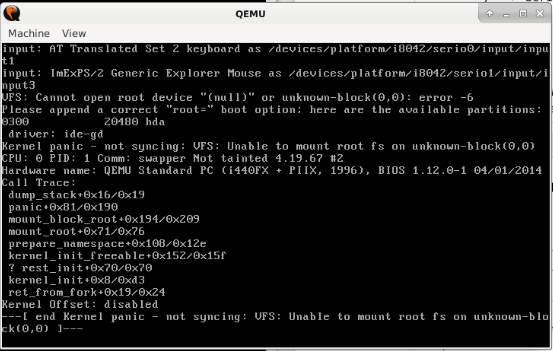

Note pela figura, que o kernel conseguiu acessar o disco virtual _rootfs.img_, mas não soube determinar qual partição de disco utilizar como sistema de arquivos raiz. Ele sugere que seja utilizado a "partição" _hda_, ou seja o disco inteiro, pois o identificador _hda_ denota o disco, se houvessem partições, seriam nomeadas a partir de _hda1_, _hda2_, e assim por diante. O parâmetro _root_ é reconhecido como o kernel para informar a partição raiz através da opção _-append_ do qemu:

```bash
$ qemu-system-x86_64 -kernel arch/x86/boot/bzImage -append "root=/dev/hda rw" ~/linux-embarcado/rootfs.img
```

# Acesso ao rootfs: OK, mas...

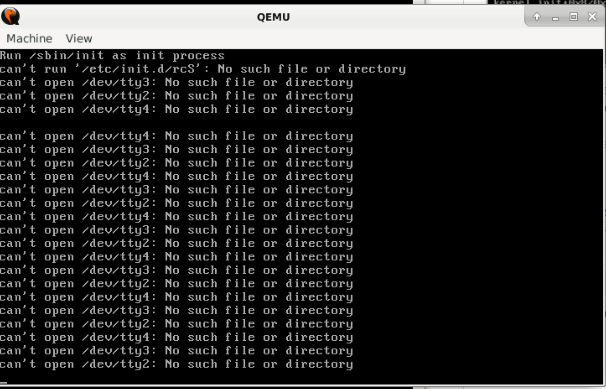
O resultado da execução provou que o linux conseguiu executar o comando _/sbin/init_ do Busybox. No entanto, o _init_, responsável pela inicialização do sistema, executa o script _/etc/init.d/rcS_ que não foi criado. Também reclamou da falta de dispositivos _/dev/tty*_ que também não é criado pelo Busybox. 

# Criando arquivos especiais de dispositivos

Para criá-los, execute:

```
$ ls -l /dev/tty[1-4*]
crw--w---- 1 root tty 4, 1 nov 10 21:23 /dev/tty1
crw--w---- 1 root tty 4, 2 nov 10 21:23 /dev/tty2
crw--w---- 1 root tty 4, 3 nov 10 21:23 /dev/tty3
crw--w---- 1 root tty 4, 4 nov 10 21:23 /dev/tty4
$ sudo mount -o loop ~/linux-embarcado/rootfs.img /mnt
$ cd /mnt; sudo mkdir dev; cd dev
$ sudo mknod tty1 c 4 1
$ sudo mknod tty2 c 4 2
$ sudo mknod tty3 c 4 3
$ sudo mknod tty4 c 4 4
$ ls -l 
crw-r--r-- 1 root root 4, 1 nov 10 22:13 tty1
crw-r--r-- 1 root root 4, 2 nov 10 22:13 tty2
crw-r--r-- 1 root root 4, 3 nov 10 22:13 tty3
crw-r--r-- 1 root root 4, 4 nov 10 22:13 tty4
$ cd; sudo umount /mnt
```
Com estes comandos, listamos os valores major e minor dos arquivos especiais de dispositivos /dev/tty*. Montamos o rootfs.img na pasta /mnt e em seguida criamos os mesmos arquivos com o comando mknod, informando o nome do arquivo e tipo de dispositivo caractere 'c'.  

# Finalmente, o shell :-)

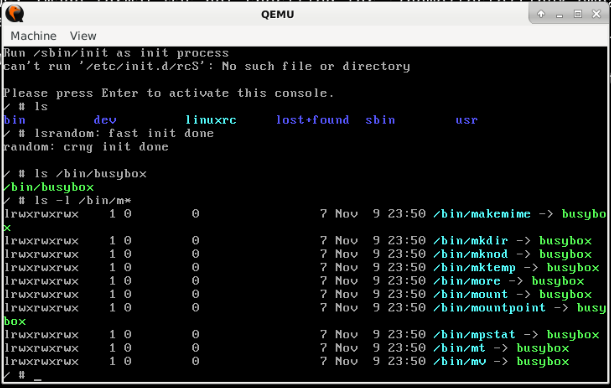

Nosso kernel+rootfs minímo que roda no qemu ficou pronto! Alguns ajustes serão disponibilizados como exercícios, mas o nosso sistema está 'operacional' com a disponibilização de um shell. Note que o _busybox_ consiste em somente um arquivo e todos os outros comandos restantes na verdade são links para o próprio busybox. Esse [desenho](https://busybox.net/FAQ.html#design) do busybox torna-o compacto, pois é necessário somente um único arquivo ELF que intepreta o nome do link simbólico que é executado. Por exemplo, quando se executa o comando _ls_, na verdade é executado um link simbólico de mesmo nome que aponta para o arquivo executável _/bin/busybox_, que por sua vez interpreta o comando _ls_ invocado.  

# Exercícios

1 - Explique alguns conceitos básicos aplicados neste tutorial:
a) O que é o qemu e como foi utilizado.
b) O que é o kernel e como foi utilizado.
c) O que é o sistema de arquivos raiz (rootfs) e como foi utilizado.
d) Explique detalhadamente toda a sequência de inicialização do SO mínimo, desde a BIOS do qemu até o shell.

2 - Ao executar o comando _halt_, o SO mínimo reclama da falta do /proc. Tem como parar a execução do SO sem criar o /proc, como? No que consiste e para que serve esse diretório? Quais são os comandos necessários para criá-lo?

3 - O _init_ reclamou da falta do arquivo /etc/init.d/rcS. Para que serve? Mostre os comandos necessários para criá-lo, utilize para montar o diretório /proc.

4 - O qemu possui algumas funcionalidades importantes para sua operação, pesquise como:
a) atalho de teclado para sair da captura do mouse
b) alternar tela cheia
c) aplicar zoom-in/zoom-out na tela
d) pesquise alguma funcionalidade de seu interesse e explique aqui

5 - Pesquise e explique para que servem os arquivos especiais de dispositivos. No procedimento de instalação do SO mínimo, foram criados os arquivos /dev/tty1 a /dev/tty4, pesquise para que servem. Na tela do qemu, experimente as combinações de teclas 'ALT+F1' até 'ALT+F4', execute o comando _tty_ e descreva o que aconteceu.

# Exercícios (cont.)

6 - Todas opções de configuração de compilação do linux é armazenada em um arquivo .config, explique o formato destes arquivos. Experimente fazer uma cópia reserva do arquivo .config para .config.bkp e depois faça alguma alteração da compilação com o comando 'make menuconfig'. Depois - com o comando diff - compare o arquivo .config.bkp anterior com o atual .config. - analise e descreva os resultados.

7 - Na compilação do busybox, a plataforma 64-bits foi assumida como padrão devido a plataforma na qual ele foi compilado. É possível compilá-lo para 32-bits? Pesquise como fazer isso e demonstre as provas do resultado. É possível executar o busybox 32-bits através de um kernel 64-bits? Recompile o kernel para 32-bits e apresente os resultados.

8 - Na configuração do Kernel, tem uma opção para Sistemas Embedded. O que essa configuração exatamente faz? Quais são os conjuntos de configurações que essa opção abre ou marca por padrão? Utilize o comando _diff_ para provar suas afirmações. 

9 - Na configuração do Kernel, pesquise pelo menos uma configuração que melhora o desempenho de sistemas dedicados a:
a) servidor que executa tarefas limitadas a CPU (CPU Bound)
b) servidor que executa tarefas limitadas a I/O (I/O Bound)
c) desktop ou celular que executa tarefas limitado a I/O (I/O Bound)
d) servidor de arquivos com arquivos de alto tamanho 
e) servidor com sistemas de arquivos com alta carga de leitura-escrita

10 - Parte do projeto: pesquise sobre o hardware emulado pelo qemu na plataforma ARM. Escolha um hardware adequado ou mais próximo para o seu projeto. Compile um kernel mínimo e informe as opções configuradas. Monte um sistema de arquivos raiz mínimo. Teste o seu SO mínimo para a plataforma ARM.